In [1]:
import matplotlib.pyplot as plt
import numpy as np

from python.dataset.data_reader import read_first
from python.util import ModelMode, DataMode
from python.km.km import KM
import python.model_util as utils

In [2]:
def get_probabilities(h, bid_range):
    distribution = []
    W = []

    prefix = 1
    for i in bid_range:
        prob = (1 - h[i]) * prefix
        distribution.append(prob)

        prefix = prefix * h[i]
        W.append(1 - prefix)

    return {'Плотность распределения': distribution, 'Вероятность выигрыша': W}

In [3]:
def draw_plot(probability_dict, bid_range, z, b):
    fig, ax = plt.subplots(1, len(probability_dict))
    fig.set_figheight(6)
    fig.set_figwidth(10)

    i = 0
    for name, values in probability_dict.items():
        ax[i].set_title('[z=%d, b=%d]' % (z, b))
        ax[i].plot(bid_range, values, label='probability')
        if z != 0 and z < b:
            ax[i].vlines(z, min(values), max(values), label='Рыночная цена', color='red')
        ax[i].vlines(b, min(values), max(values), label='Ставка аукциона', color='black', linestyle='--')
        ax[i].set_xlabel('Ставки')
        ax[i].set_ylabel('Вероятность')
        ax[i].legend()

        i += 1
    plt.show()

def draw_multiple_plot(probability_dicts, names, bid_range, z, b):
    fig, ax = plt.subplots(len(probability_dicts[0]), len(probability_dicts))
    fig.set_figheight(6)
    fig.set_figwidth(10)

    for j in range(len(probability_dicts)):
        model_name = names[j]
        i = 0
        for name, values in probability_dicts[j].items():
            ax[i][j].set_title('%s [z=%d, b=%d]' % (model_name, z, b))
            ax[i][j].plot(bid_range, values, label='probability')
            if z != 0:
                ax[i][j].vlines(z, min(values), max(values), label='market price', color='red')
            ax[i].vlines(b, min(values), max(values), label='bid', color='black', linestyle='--')
            ax[i][j].set_xlabel('bids')
            ax[i][j].set_ylabel(name)
            ax[i][j].legend()

            i += 1
    plt.show()

def draw_single_plot(probability_dicts, model_names, bid_range, z, b):
    keys = probability_dicts[0].keys()

    fig, ax = plt.subplots(1, len(keys))
    fig.set_figheight(6)
    fig.set_figwidth(10)

    for i, name in enumerate(keys):
        max_value = 0
        for j in range(len(probability_dicts)):
            values = probability_dicts[j][name]
            model_name = model_names[j]
            ax[i].plot(bid_range, values, label=model_name)
            max_value = max(max_value, max(values))

        max_value = min(1, max_value + 0.05)
        # ax[i].set_title('%s [z=%d, b=%d]' % (name, z, b))
        ax[i].set_title(name)
        if z != 0 and z < b:
            ax[i].vlines(z, 0, max_value, label='Рыночная цена', color='red')
        ax[i].vlines(b, 0, max_value, label='Ставка аукциона', color='black', linestyle='--')
        ax[i].set_xlabel('Ставки')
        ax[i].set_ylabel('Вероятность')
        ax[i].legend()
    plt.show()    

In [4]:
path = '../data'
campaign = '3476'

# dlf_0503 = utils.make_model(ModelMode.DLF, 'dlf_3476_all__0.25_0.75_0.0001_20200503_1108', training_mode=False)
# dlf_0513 = utils.make_model(ModelMode.DLF, 'dlf_3476_all__0.25_0.75_0.0001_20200513_0822', training_mode=False)
# dlf_attention = utils.make_model(ModelMode.DLF_ATTENTION, 'dlf_attention_3476_all__0.25_0.75_0.0001_20200512_1719', training_mode=False)
# dlf_vk1 = utils.make_model(ModelMode.DLF, 'dlf_vk1_all__0.25_0.75_0.0001_20200522_0106', training_mode=False)
dlf = utils.make_model(ModelMode.DLF, 'dlf_3476_all__0.25_0.75_0.0001_20200513_0822', training_mode=False)
tlf = utils.make_model(ModelMode.TRANSFORMER, 'tlf_3476_all__0.25_0.75_0.0001_20200518_1059', training_mode=False)
km = KM()
km.fit_campaign(campaign)

In [5]:
def predict_and_draw(batch):
    # dlf_h_1 = dlf_0503.predict_on_batch(batch).numpy()
    # dlf_h_2 = dlf_0513.predict_on_batch(batch).numpy()
    # dlf_attention_h = dlf_attention.predict_on_batch(batch).numpy()
    # h_vk1 = dlf_vk1.predict_on_batch(batch).numpy()
    dlf_h = dlf.predict_on_batch(batch).numpy()
    tlf_h = tlf.predict_on_batch(batch).numpy()

    bid_range = np.arange(0, 309)
    for i in range(0, len(bids), 10):
        z, b = bids[i]

        tlf_prob_dict = get_probabilities(tlf_h[i], bid_range)
        dlf_prob_dict = get_probabilities(dlf_h[i], bid_range)
        km_prob_dict = km.get_distribution(bid_range)
        # dlf_attention_prod_dict = get_probabilities(dlf_attention_h[i], bid_range)
        draw_single_plot([tlf_prob_dict, dlf_prob_dict, km_prob_dict], ['трансформер', 'baseline', 'KM'], bid_range, z, b)
        # dlf_prob_dict = get_probabilities(h_vk1[i], bid_range)
        # draw_plot(dlf_prob_dict, bid_range, z, b)

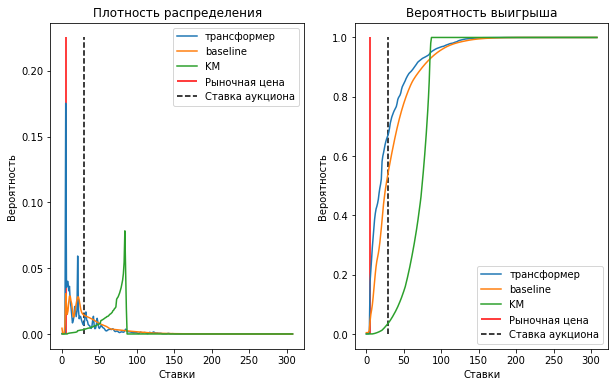

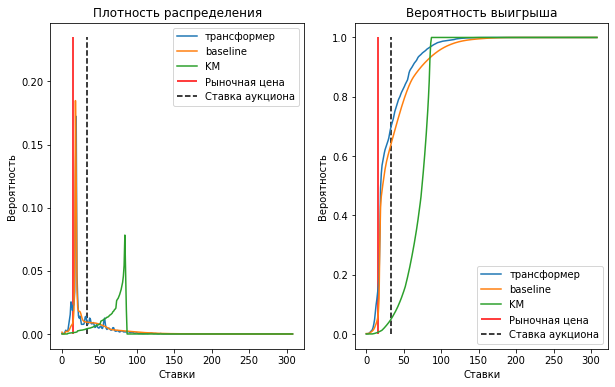

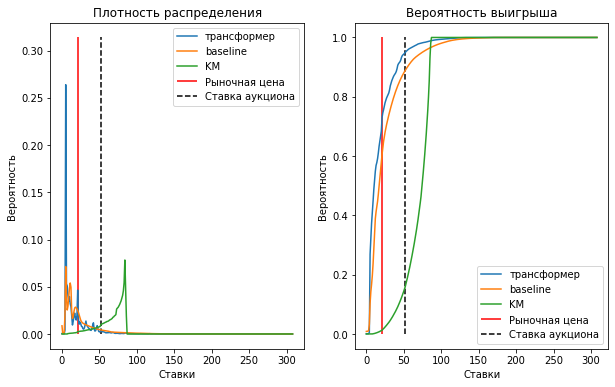

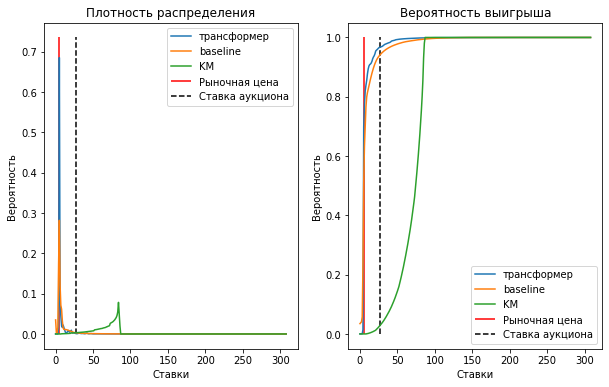

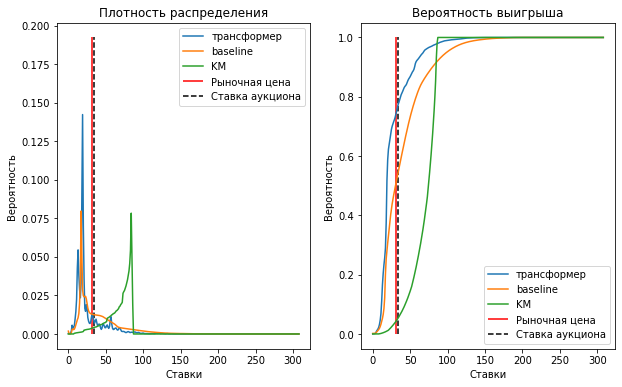

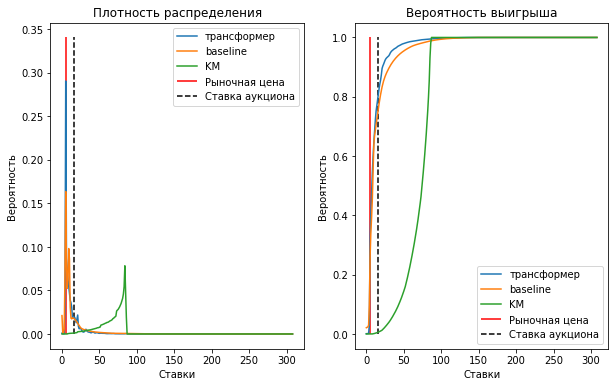

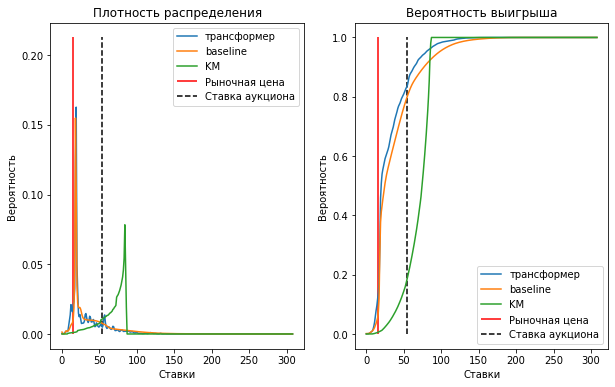

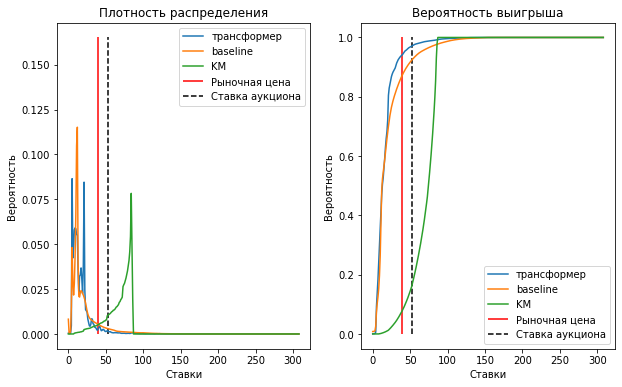

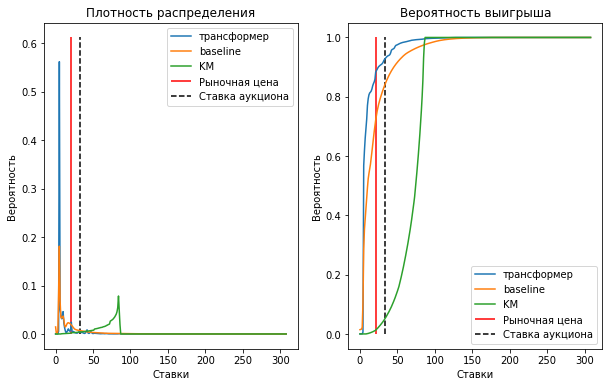

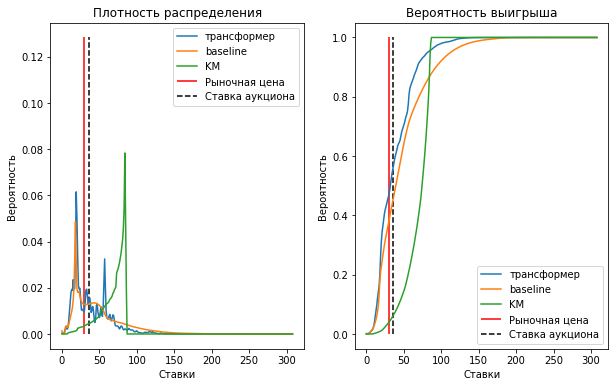

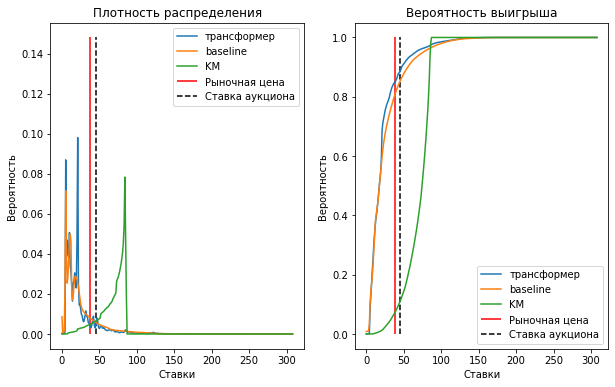

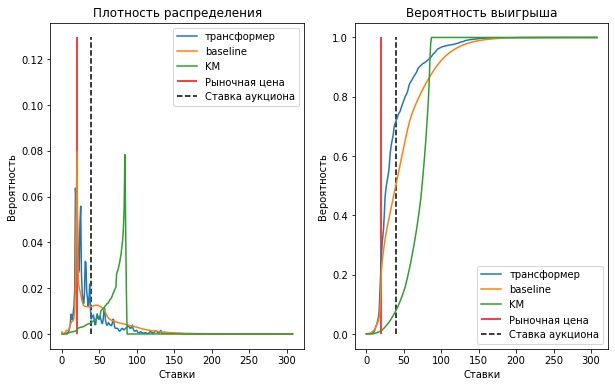

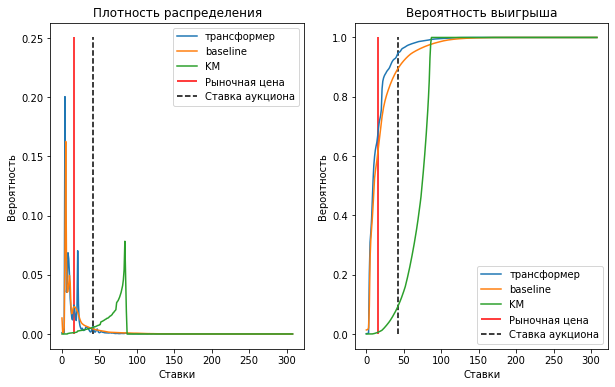

In [6]:
# Winning cases
features, bids, _, _ = read_first(path, campaign, DataMode.WIN_ONLY)
predict_and_draw([features, bids])

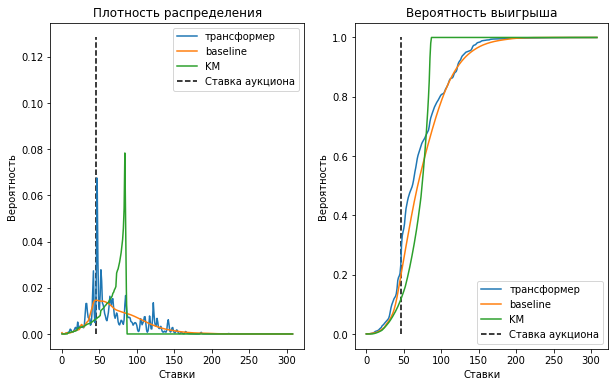

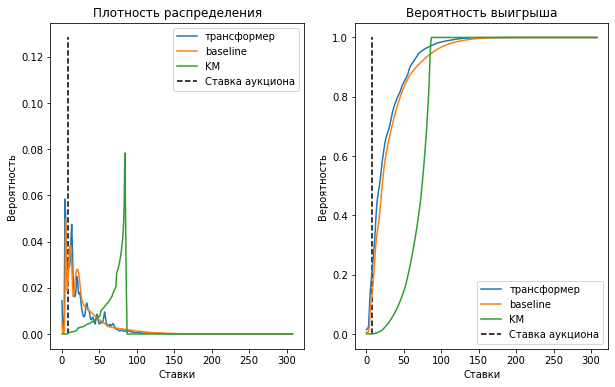

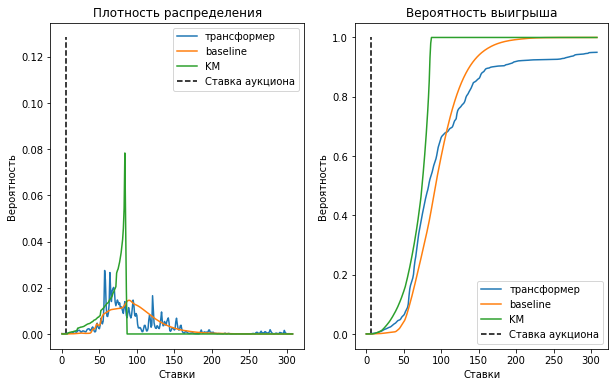

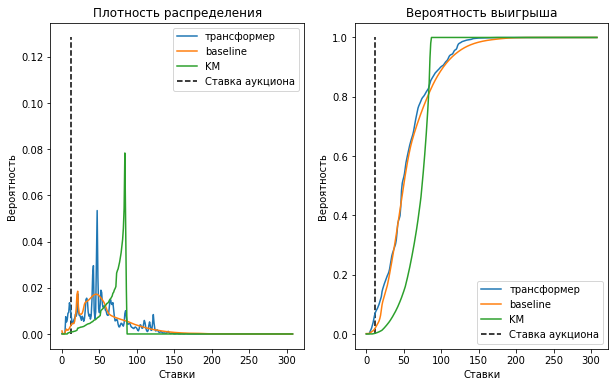

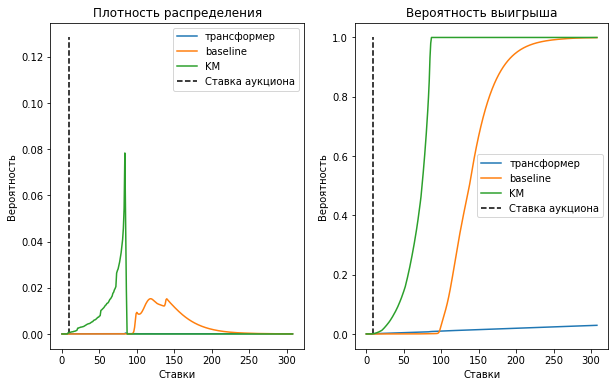

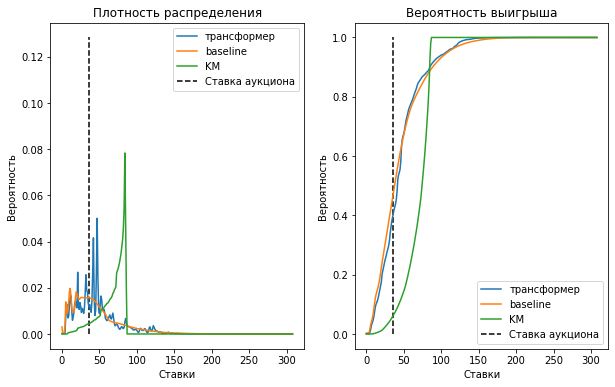

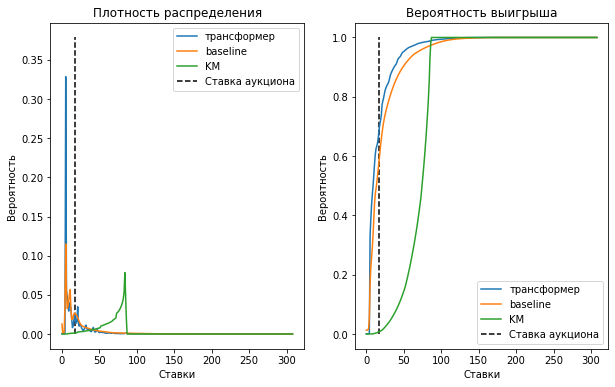

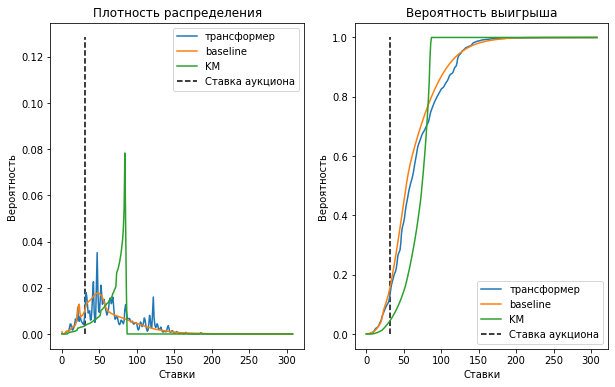

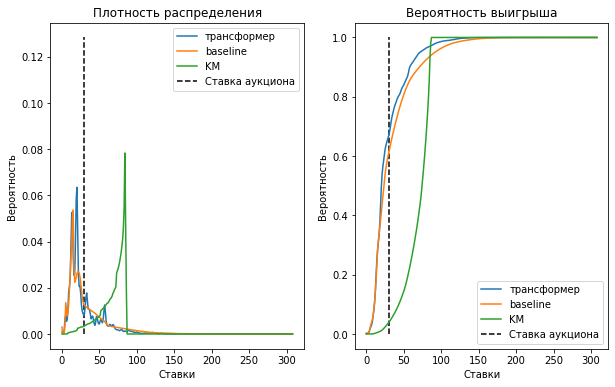

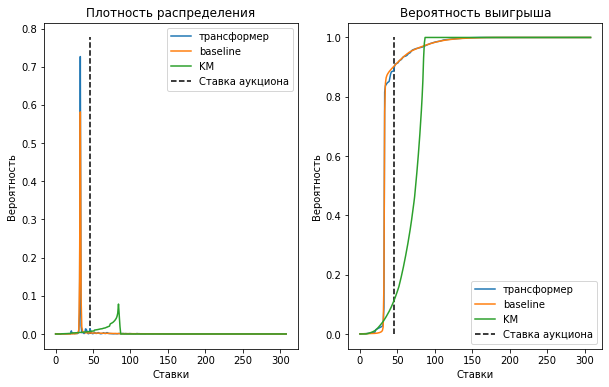

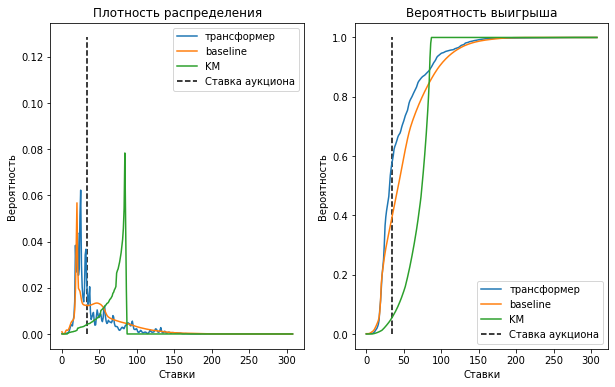

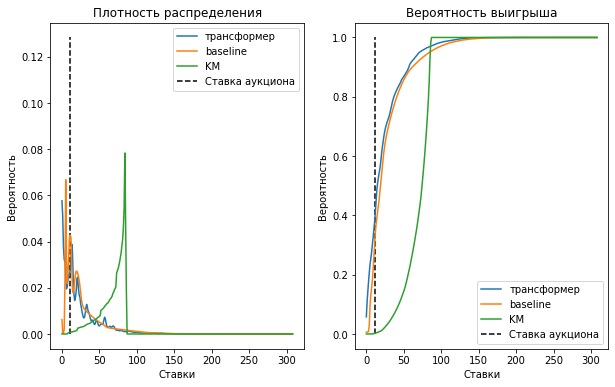

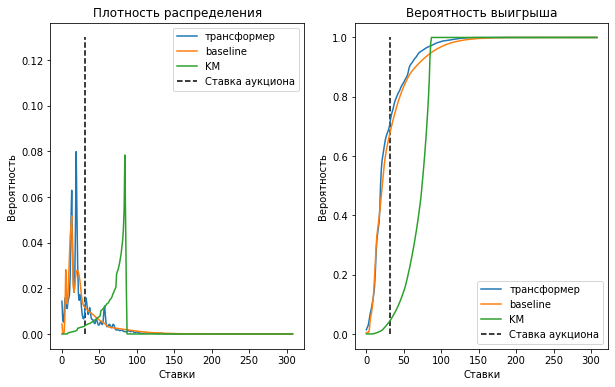

In [7]:
# Lossing cases
features, bids, _, _ = read_first(path, campaign, DataMode.LOSS_ONLY)
predict_and_draw([features, bids])